In [1]:
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# figure parameters
rcParams['figure.figsize'] = 12, 6

# read data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('./data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())
ts = data['Passengers']

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, dtype: int64
Month
1960-08-01    461.375000
1960-09-01    465.208333
1960-10-01    469.333333
1960-11-01    472.750000
1960-12-01    475.041667
Name: Passengers, dtype: float64
Month
1960-08-01    70.705808
1960-09-01    15.561869
1960-10-01   -24.688131
1960-11-01   -62.521465
1960-12-01   -34.430556
Name: Passengers, dtype: float64
Month
1960-08-01    73.919192
1960-09-01    27.229798
1960-10-01    16.354798
1960-11-01   -20.228535
1960-12-01    -8.611111
Name: Passengers, dtype: float64


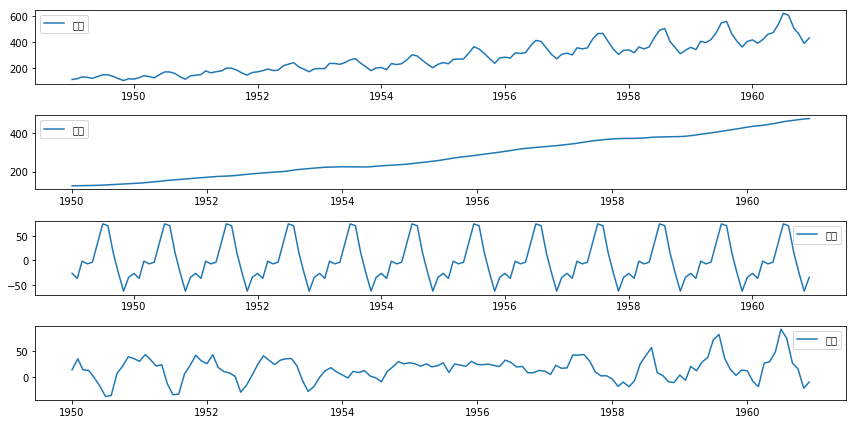

In [22]:
# decompose time series (optional)
decomposition = seasonal_decompose(ts, two_sided=False)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
residual.dropna(inplace=True)

register_matplotlib_converters()
plt.subplot(411)
plt.plot(ts, label='原始')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='趋势')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='季节')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='残差')
plt.legend(loc='best')
plt.tight_layout()
print(ts.tail())
print(trend.tail())
print(seasonal.tail())
print(residual.tail())

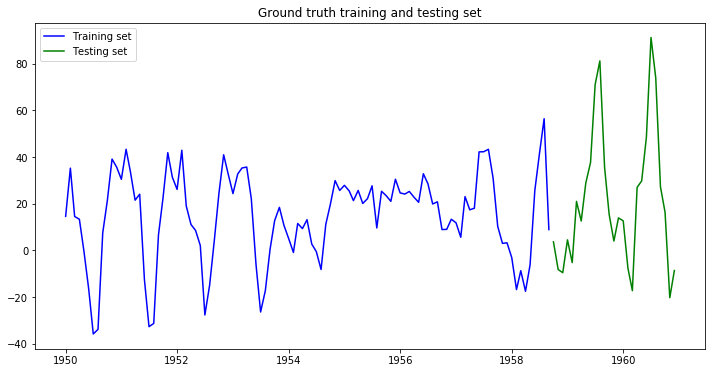

In [4]:
# create training and test set
size = int(len(residual) * 0.8)
train, test = residual[0:size], residual[size:len(residual)]
plt.plot(train.index, train, color='blue', label='Training set')
plt.plot(test.index, test, color='green', label='Testing set')
plt.legend()
plt.title('Ground truth training and testing set')
plt.show()

In [5]:
# assess quality of ARIMA models
# 对于测试集进行迭代单步预测
def compare_ARIMA_modes_testing(order):
    history = [x for x in train]
    predictions_f = list()
    predictions_p = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=-1)
        yhat_f = model_fit.forecast()[0][0]
        yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
        predictions_f.append(yhat_f)
        predictions_p.append(yhat_p)
        history.append(test[t])
    #mean_squared_error即为“误差”的平方的期望值
    error_f = mean_squared_error(test, predictions_f)
    error_p = mean_squared_error(test, predictions_p)
    print('MSE forecast:\t\t\t{:1.4f}'.format(error_f))
    print('MSE predict:\t\t\t{:1.4f}'.format(error_p))
    return {'Predictions forecast': pd.Series(predictions_f,index=test.index),
            'Predictions predict': pd.Series(predictions_p,index=test.index),
            'MSE forecast': error_f,
            'MSE predict': error_p}

In [6]:
ar_testing = compare_ARIMA_modes_testing((1, 0, 0))
ma_testing = compare_ARIMA_modes_testing((0, 1, 0))
ig_testing = compare_ARIMA_modes_testing((0, 0, 1))
arma_testing = compare_ARIMA_modes_testing((1, 1, 0))
igma_testing = compare_ARIMA_modes_testing((0, 1, 1))
arig_testing = compare_ARIMA_modes_testing((1, 0, 1))
arima_testing = compare_ARIMA_modes_testing((1, 1, 1))

MSE forecast:			468.5454
MSE predict:			468.5454
MSE forecast:			529.5507
MSE predict:			1326.5889
MSE forecast:			507.1724
MSE predict:			507.1724
MSE forecast:			524.6991
MSE predict:			1234.5120
MSE forecast:			525.0778
MSE predict:			1254.6763
MSE forecast:			435.2374
MSE predict:			435.2374
MSE forecast:			542.5189
MSE predict:			1301.9638


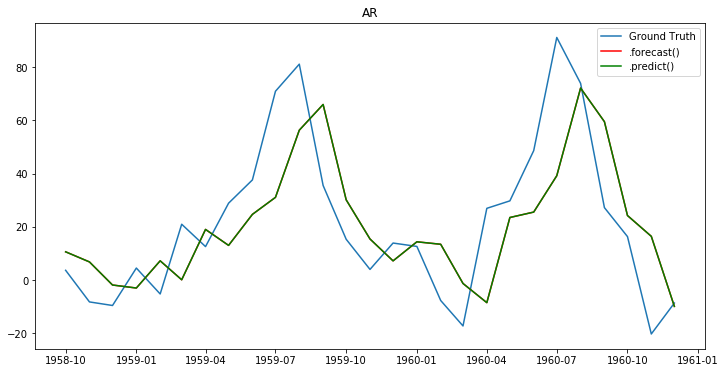

In [7]:
# forecast and predict are identical for AR
plt.plot(test, label='Ground Truth')
plt.plot(ar_testing['Predictions forecast'], color='red', label='.forecast()')
plt.plot(ar_testing['Predictions predict'], color='green', label='.predict()')
plt.legend(loc='best')
plt.title('AR')
plt.show(block=False)

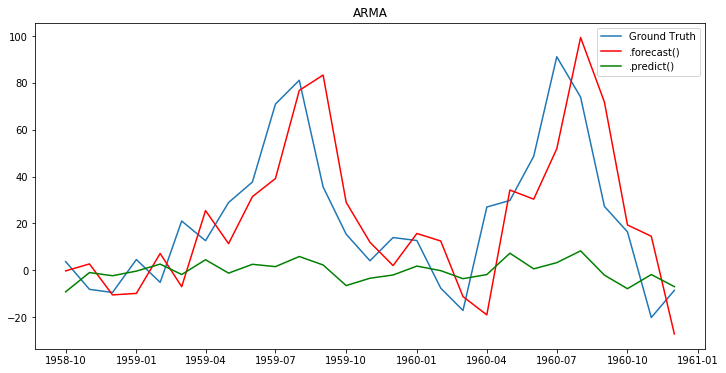

In [8]:
# forecast and predict are different for ARMA
plt.plot(test, label='Ground Truth')
plt.plot(arma_testing['Predictions forecast'], color='red', label='.forecast()')
plt.plot(arma_testing['Predictions predict'], color='green', label='.predict()')
plt.legend()
plt.title('ARMA')
plt.show()

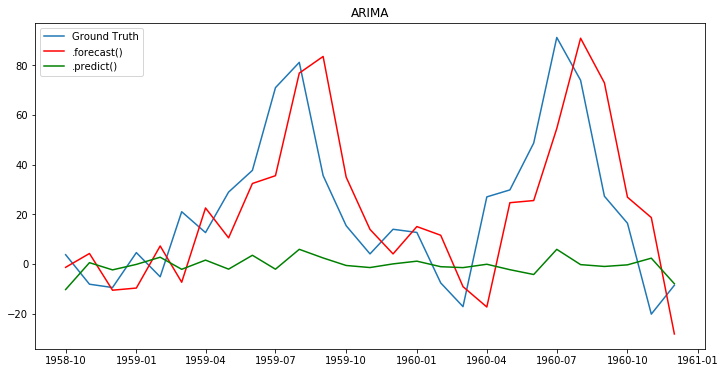

In [9]:
# forecast and predict are different for ARIMA
plt.plot(test, label='Ground Truth')
plt.plot(arima_testing['Predictions forecast'], color='red', label='.forecast()')
plt.plot(arima_testing['Predictions predict'], color='green', label='.predict()')
plt.legend()
plt.title('ARIMA')
plt.show()

In [10]:
# compare forecasting results of ARIMA models
# for iterative forecasting
def compare_ARIMA_modes(order):
    history_f = [x for x in train]
    history_p = [x for x in train]
    predictions_f = list()
    predictions_p = list()
    for t in range(len(test)):
        model_f = ARIMA(history_f, order=order)
        model_p = ARIMA(history_p, order=order)
        model_fit_f = model_f.fit(disp=-1)
        model_fit_p = model_p.fit(disp=-1)
        yhat_f = model_fit_f.forecast()[0][0]
        yhat_p = model_fit_p.predict(start=len(history_p), end=len(history_p))[0]
        predictions_f.append(yhat_f)
        predictions_p.append(yhat_p)
        history_f.append(yhat_f)
        history_f.append(yhat_p)
    error_f = mean_squared_error(test, predictions_f)
    error_p = mean_squared_error(test, predictions_p)
    print('MSE forecast:\t\t\t{:1.4f}'.format(error_f))
    print('MSE predict:\t\t\t{:1.4f}'.format(error_p))
    return {'Predictions forecast': pd.Series(predictions_f,index=test.index),
            'Predictions predict': pd.Series(predictions_p,index=test.index),
            'MSE forecast': error_f,
            'MSE predict': error_p}

In [11]:
ar = compare_ARIMA_modes((1, 0, 0))
ma = compare_ARIMA_modes((0, 1, 0))
ig = compare_ARIMA_modes((0, 0, 1))
arma = compare_ARIMA_modes((1, 1, 0))
igma = compare_ARIMA_modes((0, 1, 1))
arig = compare_ARIMA_modes((1, 0, 1))
arima = compare_ARIMA_modes((1, 1, 1))

MSE forecast:			975.5431
MSE predict:			995.8647
MSE forecast:			1346.7559
MSE predict:			1341.5529
MSE forecast:			1300.4122
MSE predict:			1562.0202
MSE forecast:			1822.4260
MSE predict:			1821.9169
MSE forecast:			1888.1598
MSE predict:			1887.7159
MSE forecast:			1312.4914
MSE predict:			1440.7830
MSE forecast:			1889.4207
MSE predict:			1889.1150


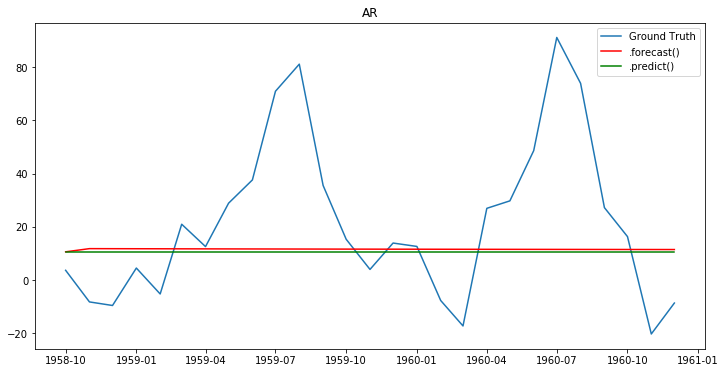

In [12]:
# forecast and predict are different for AR
plt.plot(test, label='Ground Truth')
plt.plot(ar['Predictions forecast'], color='red', label='.forecast()')
plt.plot(ar['Predictions predict'], color='green', label='.predict()')
plt.legend()
plt.title('AR')
plt.show()

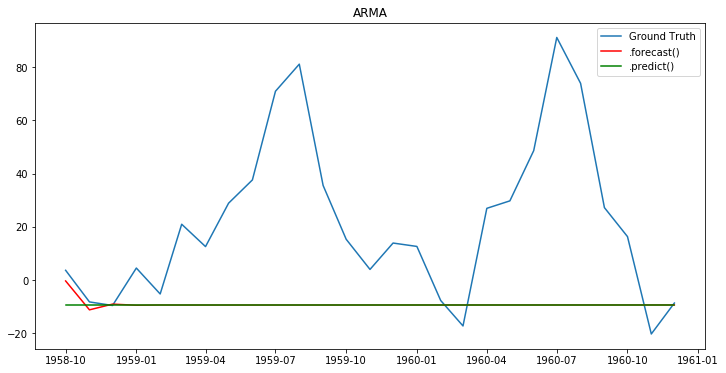

In [13]:
# forecast and predict are different for ARMA
plt.plot(test, label='Ground Truth')
plt.plot(arma['Predictions forecast'], color='red', label='.forecast()')
plt.plot(arma['Predictions predict'], color='green', label='.predict()')
plt.legend()
plt.title('ARMA')
plt.show()

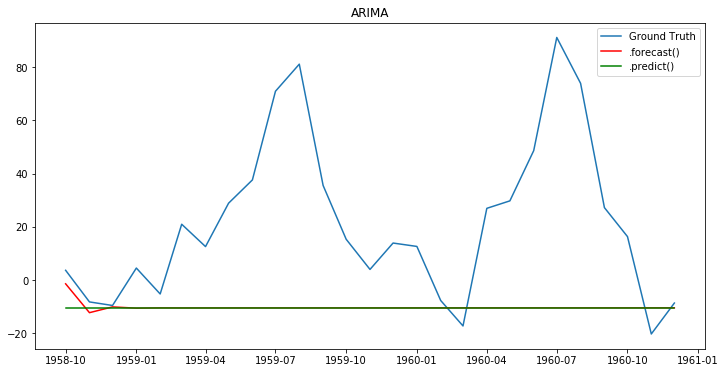

In [14]:
# forecast and predict are different for ARIMA
plt.plot(test, label='Ground Truth')
plt.plot(arima['Predictions forecast'], color='red', label='.forecast()')
plt.plot(arima['Predictions predict'], color='green', label='.predict()')
plt.legend()
plt.title('ARIMA')
plt.show()

In [15]:
# compare forecasting results of ARIMA models
# using the step parameter
def compare_ARIMA_modes_steps(order):
    history = [x for x in train]
    model = ARIMA(history, order=order)
    model_fit = model.fit(disp=-1)
    predictions_f_ms = model_fit.forecast(steps=len(test))[0]
    predictions_p_ms = model_fit.predict(start=len(history), end=len(history)+len(test)-1)
    error_f_ms = mean_squared_error(test, predictions_f_ms)
    error_p_ms = mean_squared_error(test, predictions_p_ms)
    print('MSE forecast:\t\t\t{:1.4f}'.format(error_f_ms))
    print('MSE predict:\t\t\t{:1.4f}'.format(error_p_ms))
    return {'Predictions forecast': pd.Series(predictions_f_ms,index=test.index),
            'Predictions predict': pd.Series(predictions_p_ms,index=test.index),
            'MSE forecast': error_f_ms,
            'MSE predict': error_p_ms}

In [16]:
ar_steps = compare_ARIMA_modes_steps((1, 0, 0))
ma_steps = compare_ARIMA_modes_steps((0, 1, 0))
ig_steps = compare_ARIMA_modes_steps((0, 0, 1))
arma_steps = compare_ARIMA_modes_steps((1, 1, 0))
igma_steps = compare_ARIMA_modes_steps((0, 1, 1))
arig_steps = compare_ARIMA_modes_steps((1, 0, 1))
arima_steps = compare_ARIMA_modes_steps((1, 1, 1))

MSE forecast:			912.3160
MSE predict:			912.3160
MSE forecast:			1059.3526
MSE predict:			1341.5529
MSE forecast:			923.3921
MSE predict:			923.3921
MSE forecast:			1535.7747
MSE predict:			1348.7032
MSE forecast:			1471.3281
MSE predict:			1350.3882
MSE forecast:			902.2501
MSE predict:			902.2501
MSE forecast:			1491.6448
MSE predict:			1350.3205


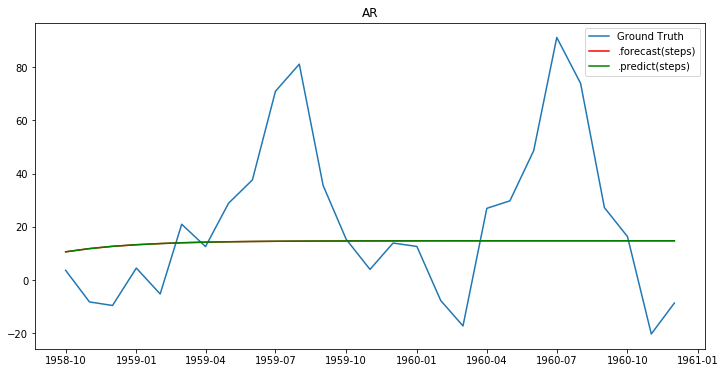

In [17]:
# forecast and predict are identical for AR
plt.plot(test, label='Ground Truth')
plt.plot(ar_steps['Predictions forecast'], color='red', label='.forecast(steps)')
plt.plot(ar_steps['Predictions predict'], color='green', label='.predict(steps)')
plt.legend()
plt.title('AR')
plt.show()

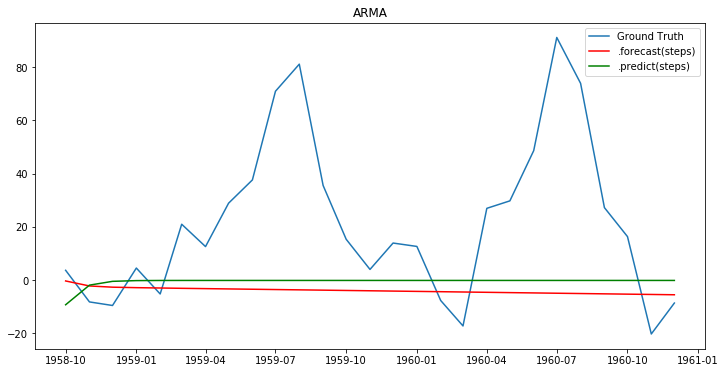

In [18]:
# forecast and predict are different for ARMA
plt.plot(test, label='Ground Truth')
plt.plot(arma_steps['Predictions forecast'],  color='red', label='.forecast(steps)')
plt.plot(arma_steps['Predictions predict'], color='green', label='.predict(steps)')
plt.legend()
plt.title('ARMA')
plt.show()